In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from glob import glob
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f'Num of available GPU: {len(physical_devices)}')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.debugging.set_log_device_placement(True)

train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory('.\CatsNDogs\Data_cats_and_dogs\Train',
                                             target_size=(200, 200),
                                             batch_size=64,
                                             class_mode='binary')

validation_dataset = test.flow_from_directory('.\CatsNDogs\Data_cats_and_dogs\Validation',
                                           target_size=(200, 200),
                                           batch_size=64,
                                           class_mode='binary')

test_dataset_path_cats = r'.\CatsNDogs\Data_cats_and_dogs\Test\Cat'
test_dataset_path_dogs = r'.\CatsNDogs\Data_cats_and_dogs\Test\Dog'
test_images_cats = glob(test_dataset_path_cats + '/*.*')
test_images_dogs = glob(test_dataset_path_dogs + '/*.*')

dataframe_test = pd.DataFrame()
list_image, list_label  = [], []
for img in tqdm(test_images_cats):
    img = cv2.imread(img)
    list_image.append(img)
    list_label.append(0)
for img in tqdm(test_images_dogs):
    img = cv2.imread(img)
    list_image.append(img)
    list_label.append(1)
    
dataframe_test['image'] = list_image
dataframe_test['label'] = list_label

print(train_dataset.class_indices)
print(f'Test dataframe shape: {dataframe_test.shape}')

Num of available GPU: 1
Found 7715 images belonging to 2 classes.
Found 1998 images belonging to 2 classes.


100%|██████████| 1226/1226 [00:35<00:00, 34.56it/s]


{'Cat': 0, 'Dog': 1}
Test dataframe shape: (1966, 2)


In [3]:
def drawPlot(history):
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Model accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.plot(history.history['accuracy'], label='Training data')
    ax1.plot(history.history['val_accuracy'], label='Validation data')
    ax1.legend(loc='best')
    ax1.grid(True)
    ax2 = fig.add_subplot(212)
    ax2.set_title('Model loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.plot(history.history['loss'], label='Training data')
    ax2.plot(history.history['val_loss'], label='Validation data')
    ax2.legend(loc='best')
    ax2.grid(True)

def trainModel(model, train_dataset, test_dataset, epochs=10, batch_size=64):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    try:
        with tf.device('/device:GPU:0'):
            history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=test_dataset, verbose=1, callbacks=[early_stop])
    except RuntimeError as e:
        print(e)
    return history

In [4]:
def modelCNNWithOneLayer(train_dataset, test_dataset):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    history = trainModel(model, train_dataset, test_dataset)
    return model, history


def modelCNNWithTwoLayer(train_dataset, test_dataset):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    history = trainModel(model, train_dataset, test_dataset, epochs=10)
    return model, history

def modelCNNWithThreeLayer(train_dataset, test_dataset):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    history = trainModel(model, train_dataset, test_dataset, epochs=15)
    return model, history

def modelCNNWithFourLayer(train_dataset, test_dataset):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.MaxPool2D(3, 3))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    history = trainModel(model, train_dataset, test_dataset, epochs=20)
    return model, history

def modelCNNWithFiveLayer(train_dataset, test_dataset):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.MaxPool2D(3, 3))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    history = trainModel(model, train_dataset, test_dataset, epochs=20)
    return model, history

def modelCNNWithFiveLayerDropout(train_dataset, test_dataset):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.MaxPool2D(3, 3))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    history = trainModel(model, train_dataset, test_dataset, epochs=25)
    return model, history

In [5]:
model_CNN_one_layer, history_CNN_one_layer = modelCNNWithOneLayer(train_dataset, validation_dataset)

Epoch 1/10
121/121 [==============================] - 75s 617ms/step - loss: 0.6840 - accuracy: 0.5605 - val_loss: 0.6733 - val_accuracy: 0.5761
Epoch 2/10
121/121 [==============================] - 69s 571ms/step - loss: 0.6569 - accuracy: 0.6088 - val_loss: 0.6609 - val_accuracy: 0.5936
Epoch 3/10
121/121 [==============================] - 70s 577ms/step - loss: 0.6422 - accuracy: 0.6218 - val_loss: 0.6418 - val_accuracy: 0.6216
Epoch 4/10
121/121 [==============================] - 74s 613ms/step - loss: 0.6260 - accuracy: 0.6450 - val_loss: 0.6266 - val_accuracy: 0.6371
Epoch 5/10
121/121 [==============================] - 63s 519ms/step - loss: 0.6187 - accuracy: 0.6467 - val_loss: 0.6308 - val_accuracy: 0.6251
Epoch 6/10
121/121 [==============================] - 58s 480ms/step - loss: 0.6047 - accuracy: 0.6608 - val_loss: 0.6323 - val_accuracy: 0.6336
Epoch 7/10
121/121 [==============================] - 57s 474ms/step - loss: 0.5955 - accuracy: 0.6721 - val_loss: 0.6336 - val_ac

In [6]:
model_CNN_two_layer, history_CNN_two_layer = modelCNNWithTwoLayer(train_dataset, validation_dataset)

Epoch 1/10
121/121 [==============================] - 74s 614ms/step - loss: 0.6875 - accuracy: 0.5703 - val_loss: 0.6308 - val_accuracy: 0.6567
Epoch 2/10
121/121 [==============================] - 72s 592ms/step - loss: 0.5835 - accuracy: 0.6832 - val_loss: 0.5991 - val_accuracy: 0.6792
Epoch 3/10
121/121 [==============================] - 72s 598ms/step - loss: 0.5045 - accuracy: 0.7541 - val_loss: 0.5422 - val_accuracy: 0.7237
Epoch 4/10
121/121 [==============================] - 74s 609ms/step - loss: 0.4303 - accuracy: 0.8022 - val_loss: 0.5750 - val_accuracy: 0.7222
Epoch 5/10
121/121 [==============================] - 72s 596ms/step - loss: 0.3504 - accuracy: 0.8433 - val_loss: 0.5543 - val_accuracy: 0.7282
Epoch 6/10
121/121 [==============================] - 73s 605ms/step - loss: 0.2677 - accuracy: 0.8870 - val_loss: 0.6121 - val_accuracy: 0.7327
Epoch 7/10
121/121 [==============================] - 76s 624ms/step - loss: 0.1771 - accuracy: 0.9299 - val_loss: 0.6935 - val_ac

In [8]:
model_CNN_three_layer, history_CNN_three_layer = modelCNNWithThreeLayer(train_dataset, validation_dataset)

Epoch 1/15
121/121 [==============================] - 84s 693ms/step - loss: 0.6874 - accuracy: 0.5515 - val_loss: 0.6689 - val_accuracy: 0.5916
Epoch 2/15
121/121 [==============================] - 81s 671ms/step - loss: 0.6626 - accuracy: 0.6053 - val_loss: 0.6466 - val_accuracy: 0.6371
Epoch 3/15
121/121 [==============================] - 81s 673ms/step - loss: 0.6426 - accuracy: 0.6312 - val_loss: 0.6377 - val_accuracy: 0.6246
Epoch 4/15
121/121 [==============================] - 82s 681ms/step - loss: 0.6168 - accuracy: 0.6573 - val_loss: 0.6137 - val_accuracy: 0.6647
Epoch 5/15
121/121 [==============================] - 85s 706ms/step - loss: 0.5948 - accuracy: 0.6836 - val_loss: 0.5957 - val_accuracy: 0.6782
Epoch 6/15
121/121 [==============================] - 89s 735ms/step - loss: 0.5764 - accuracy: 0.7017 - val_loss: 0.5805 - val_accuracy: 0.6972
Epoch 7/15
121/121 [==============================] - 88s 726ms/step - loss: 0.5488 - accuracy: 0.7178 - val_loss: 0.5684 - val_ac

In [9]:
model_CNN_four_layer, history_CNN_four_layer = modelCNNWithFourLayer(train_dataset, validation_dataset)

Epoch 1/20
121/121 [==============================] - 35s 287ms/step - loss: 0.6894 - accuracy: 0.5287 - val_loss: 0.6876 - val_accuracy: 0.5005
Epoch 2/20
121/121 [==============================] - 56s 460ms/step - loss: 0.6821 - accuracy: 0.5633 - val_loss: 0.6777 - val_accuracy: 0.5666
Epoch 3/20
121/121 [==============================] - 44s 360ms/step - loss: 0.6705 - accuracy: 0.5863 - val_loss: 0.6588 - val_accuracy: 0.6176
Epoch 4/20
121/121 [==============================] - 49s 405ms/step - loss: 0.6555 - accuracy: 0.6176 - val_loss: 0.6407 - val_accuracy: 0.6266
Epoch 5/20
121/121 [==============================] - 47s 385ms/step - loss: 0.6464 - accuracy: 0.6259 - val_loss: 0.6360 - val_accuracy: 0.6416
Epoch 6/20
121/121 [==============================] - 51s 419ms/step - loss: 0.6339 - accuracy: 0.6359 - val_loss: 0.6262 - val_accuracy: 0.6517
Epoch 7/20
121/121 [==============================] - 54s 449ms/step - loss: 0.6252 - accuracy: 0.6503 - val_loss: 0.6219 - val_ac

In [10]:
model_CNN_five_layer, history_CNN_five_layer = modelCNNWithFiveLayer(train_dataset, validation_dataset)

Epoch 1/20
121/121 [==============================] - 60s 496ms/step - loss: 0.6881 - accuracy: 0.5326 - val_loss: 0.6852 - val_accuracy: 0.5040
Epoch 2/20
121/121 [==============================] - 45s 370ms/step - loss: 0.6668 - accuracy: 0.5999 - val_loss: 0.6569 - val_accuracy: 0.6016
Epoch 3/20
121/121 [==============================] - 56s 467ms/step - loss: 0.6312 - accuracy: 0.6441 - val_loss: 0.6200 - val_accuracy: 0.6582
Epoch 4/20
121/121 [==============================] - 57s 473ms/step - loss: 0.5924 - accuracy: 0.6797 - val_loss: 0.5706 - val_accuracy: 0.7012
Epoch 5/20
121/121 [==============================] - 56s 466ms/step - loss: 0.5473 - accuracy: 0.7251 - val_loss: 0.5091 - val_accuracy: 0.7673
Epoch 6/20
121/121 [==============================] - 60s 495ms/step - loss: 0.5011 - accuracy: 0.7531 - val_loss: 0.4991 - val_accuracy: 0.7628
Epoch 7/20
121/121 [==============================] - 48s 400ms/step - loss: 0.4634 - accuracy: 0.7773 - val_loss: 0.4446 - val_ac

In [11]:
model_CNN_five_layer_dropout, history_CNN_five_layer_dropout = modelCNNWithFiveLayerDropout(train_dataset, validation_dataset)

Epoch 1/25
121/121 [==============================] - 23s 187ms/step - loss: 0.6897 - accuracy: 0.5321 - val_loss: 0.6830 - val_accuracy: 0.5991
Epoch 2/25
121/121 [==============================] - 22s 185ms/step - loss: 0.6678 - accuracy: 0.5975 - val_loss: 0.6794 - val_accuracy: 0.5581
Epoch 3/25
121/121 [==============================] - 22s 181ms/step - loss: 0.6379 - accuracy: 0.6372 - val_loss: 0.6115 - val_accuracy: 0.6667
Epoch 4/25
121/121 [==============================] - 21s 174ms/step - loss: 0.6043 - accuracy: 0.6703 - val_loss: 0.6180 - val_accuracy: 0.6577
Epoch 5/25
121/121 [==============================] - 21s 171ms/step - loss: 0.5720 - accuracy: 0.6968 - val_loss: 0.5994 - val_accuracy: 0.6737
Epoch 6/25
121/121 [==============================] - 21s 172ms/step - loss: 0.5307 - accuracy: 0.7335 - val_loss: 0.5888 - val_accuracy: 0.6882
Epoch 7/25
121/121 [==============================] - 21s 177ms/step - loss: 0.5036 - accuracy: 0.7519 - val_loss: 0.5340 - val_ac

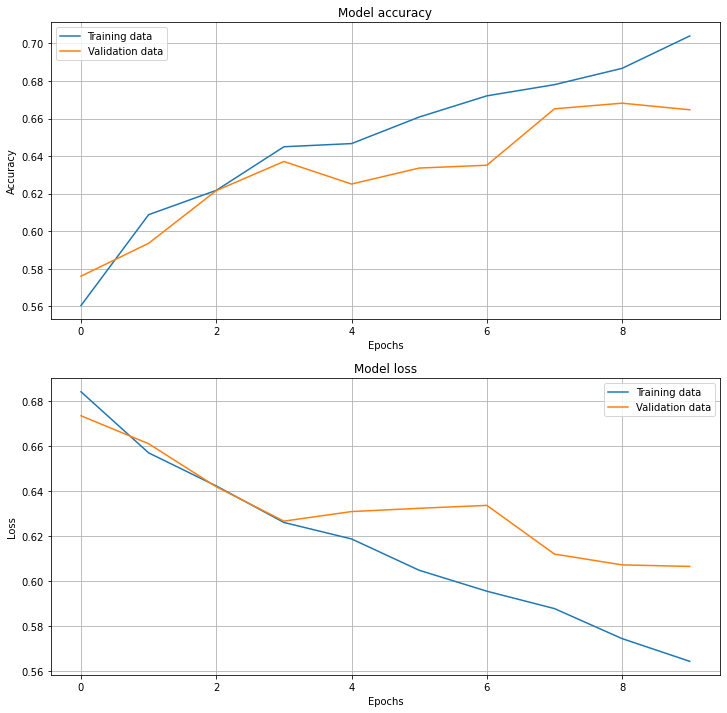

In [21]:
drawPlot(history_CNN_one_layer[1])

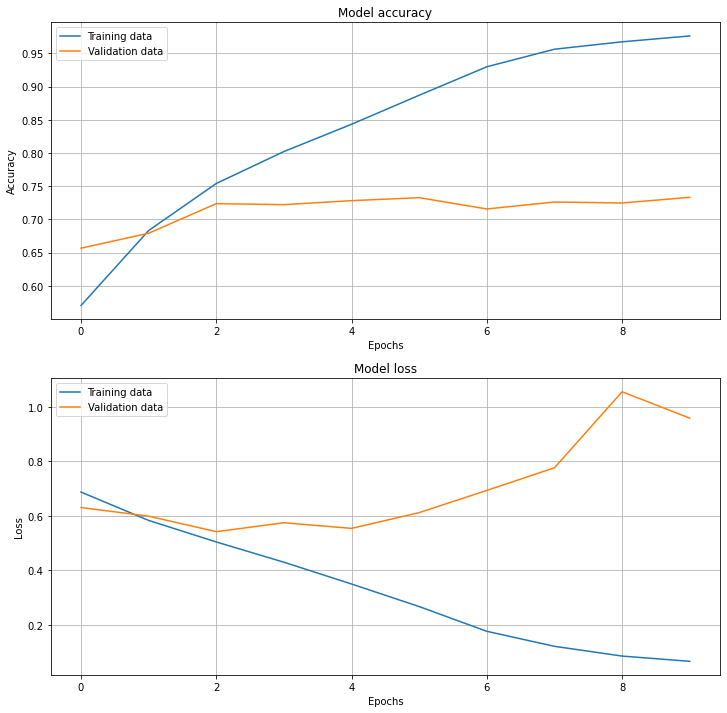

In [22]:
drawPlot(history_CNN_two_layer[1])

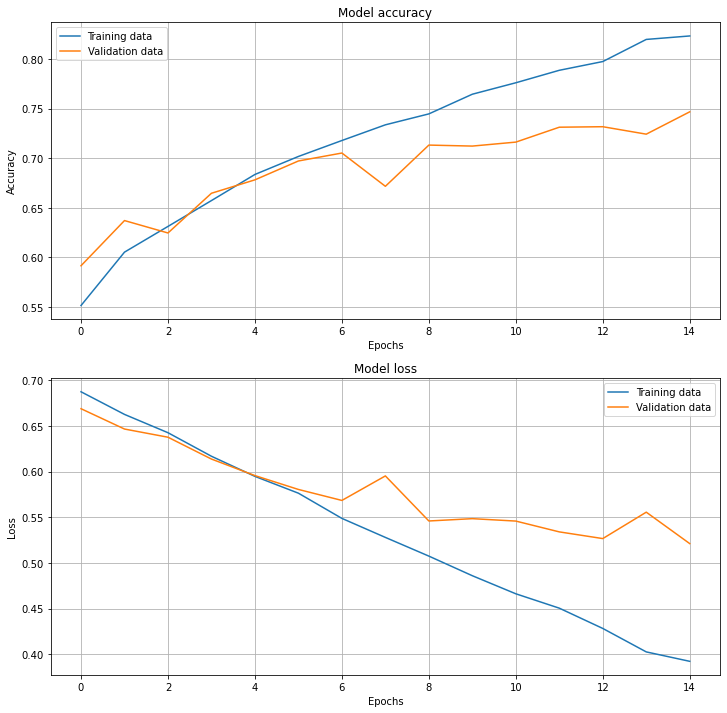

In [24]:
drawPlot(history_CNN_three_layer[1])

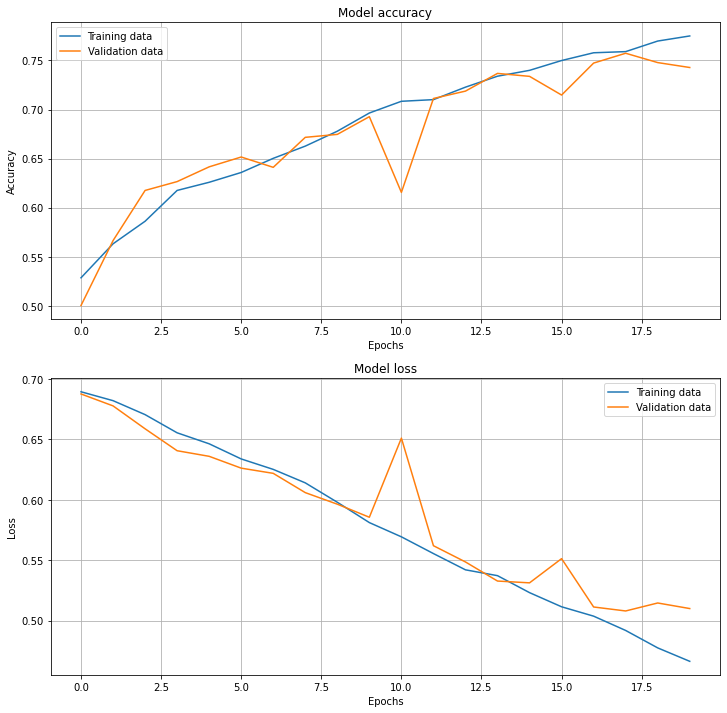

In [25]:
drawPlot(history_CNN_four_layer[1])

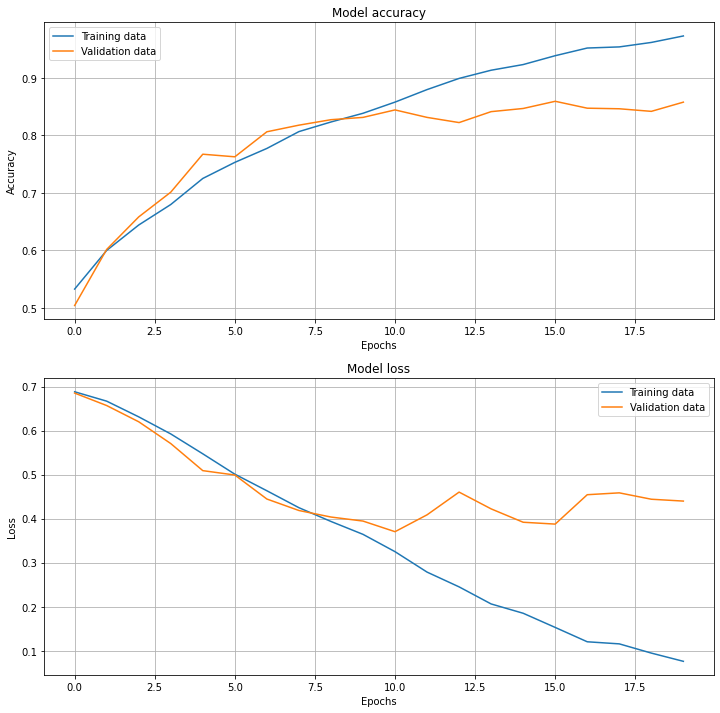

In [26]:
drawPlot(history_CNN_five_layer[1])

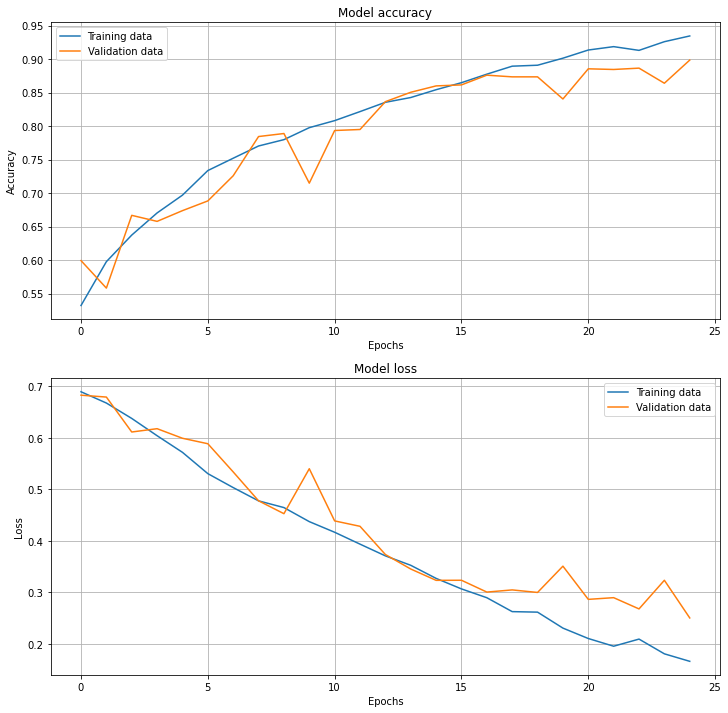

In [28]:
drawPlot(history_CNN_five_layer_dropout[1])

In [5]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

dataframe_test = shuffle(dataframe_test).reset_index(drop=True)
X_test = dataframe_test['image']
y_test = dataframe_test['label']

In [55]:
prediction = []
for img in tqdm(X_test):
    img = np.expand_dims(img, axis=0)
    result = model_CNN_five_layer_dropout.predict(img)
    prediction.append(int(result))

100%|██████████| 1966/1966 [01:42<00:00, 19.20it/s]


In [56]:
accuracy_score(y_test, prediction)

0.8280773143438453

In [58]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.82      0.70      0.75       740
           1       0.83      0.90      0.87      1226

    accuracy                           0.83      1966
   macro avg       0.82      0.80      0.81      1966
weighted avg       0.83      0.83      0.83      1966



<AxesSubplot:>

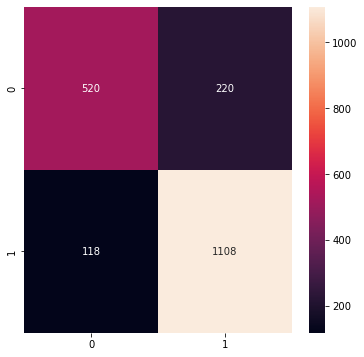

In [64]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt="d", ax=ax)

In [4]:
import keras_tuner 

In [14]:
def perfectModel(hp): #of course it is not XD
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=hp.Int(name = 'conv_filter_1', min_value = 32, max_value = 512, step = 32),
                                     kernel_size=hp.Int(name = 'conv_filter_1', min_value = 2, max_value = 4, step = 1),
                                     activation='relu',
                                     padding='same',
                                     input_shape=(200, 200, 3)))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=(3, 3)))
    model.add(tf.keras.layers.Conv2D(filters=hp.Int(name = 'conv_filter_2', min_value = 32, max_value = 512, step = 32),
                                     kernel_size=hp.Int(name = 'conv_filter_2', min_value = 2, max_value = 4, step = 1),
                                     activation='relu',
                                     padding='same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=(3, 3)))
    model.add(tf.keras.layers.Conv2D(filters=hp.Int(name = 'conv_filter_3', min_value = 32, max_value = 512, step = 32),
                                     kernel_size=hp.Int(name = 'conv_filter_3', min_value = 2, max_value = 4, step = 1),
                                     activation='relu',
                                     padding='same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(rate=hp.Float(name = 'dropout_1', min_value = 0.2, max_value = 0.5, step = 0.1)))
    model.add(tf.keras.layers.Conv2D(filters=hp.Int(name = 'conv_filter_4', min_value = 32, max_value = 512, step = 32),
                                     kernel_size=hp.Int(name = 'conv_filter_4', min_value = 2, max_value = 4, step = 1),
                                     activation='relu',
                                     padding='same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.Dropout(rate=hp.Float(name = 'dropout_2', min_value = 0.2, max_value = 0.5, step = 0.1)))
    model.add(tf.keras.layers.Conv2D(filters=hp.Int(name = 'conv_filter_5', min_value = 32, max_value = 512, step = 32),
                                     kernel_size=hp.Int(name = 'conv_filter_5', min_value = 2, max_value = 4, step = 1),
                                     activation='relu',
                                     padding='same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(rate=hp.Float(name = 'dropout_3', min_value = 0.2, max_value = 0.5, step = 0.1)))
    model.add(tf.keras.layers.Dense(units=hp.Int(name = 'dense_unit_1', min_value = 128, max_value = 512, step = 128),
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(units=hp.Int(name = 'dense_unit_2', min_value = 128, max_value = 512, step = 128),
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(units=hp.Int(name = 'dense_unit_3', min_value = 128, max_value = 512, step = 128),
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.SGD(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001]), decay=1e-6, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.BinaryCrossentropy()
    
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [32]:
tuner = keras_tuner.Hyperband(perfectModel,
                              objective='val_accuracy', 
                              max_epochs=10,
                              factor=3)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json


In [1]:
tuner.search(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[early_stop])

NameError: name 'tuner' is not defined

In [4]:
def betterModel(train_dataset, test_dataset):
    model = tf.keras.Sequential()
    #Layer 1 
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.MaxPool2D((3, 3), strides=(3, 3)))
    model.add(tf.keras.layers.Dropout(0.2))
    #Layer 2
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D((3, 3), strides=(3, 3)))
    model.add(tf.keras.layers.Dropout(0.2))
    #Layer 3
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    #Layer 4
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    #Layer 5
    model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    #Layer 6
    model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    #optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    #optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.1, epsilon=1e-06, centered=False)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    history = trainModel(model, train_dataset, test_dataset, epochs=30)
    
    return model, history

In [5]:
model, history = betterModel(train_dataset, validation_dataset)

Epoch 1/30
121/121 [==============================] - 59s 489ms/step - loss: 0.7012 - accuracy: 0.5160 - val_loss: 0.6931 - val_accuracy: 0.4990
Epoch 2/30
121/121 [==============================] - 52s 432ms/step - loss: 0.6908 - accuracy: 0.5335 - val_loss: 0.6896 - val_accuracy: 0.5315
Epoch 3/30
121/121 [==============================] - 23s 194ms/step - loss: 0.6781 - accuracy: 0.5689 - val_loss: 0.6530 - val_accuracy: 0.6126
Epoch 4/30
121/121 [==============================] - 25s 210ms/step - loss: 0.6363 - accuracy: 0.6324 - val_loss: 0.6109 - val_accuracy: 0.6667
Epoch 5/30
121/121 [==============================] - 22s 185ms/step - loss: 0.5845 - accuracy: 0.6896 - val_loss: 0.5691 - val_accuracy: 0.7022
Epoch 6/30
121/121 [==============================] - 22s 183ms/step - loss: 0.5376 - accuracy: 0.7332 - val_loss: 0.4958 - val_accuracy: 0.7528
Epoch 7/30
121/121 [==============================] - 22s 185ms/step - loss: 0.4968 - accuracy: 0.7629 - val_loss: 0.4733 - val_ac

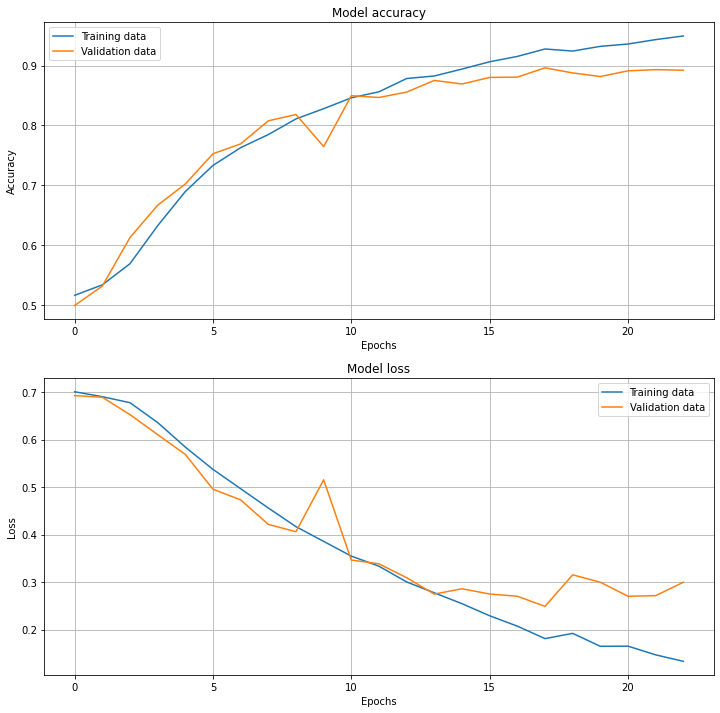

In [6]:
drawPlot(history)

In [8]:
prediction = []
for img in tqdm(X_test):
    img = np.expand_dims(img, axis=0)
    result = model.predict(img)
    prediction.append(int(result))

100%|██████████| 1966/1966 [02:22<00:00, 13.82it/s]


In [10]:
accuracy_score(y_test, prediction)

0.8392675483214649

In [11]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       740
           1       0.87      0.87      0.87      1226

    accuracy                           0.84      1966
   macro avg       0.83      0.83      0.83      1966
weighted avg       0.84      0.84      0.84      1966



<AxesSubplot:>

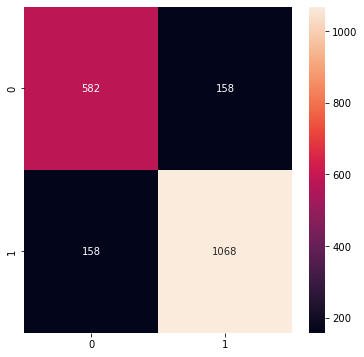

In [12]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt="d", ax=ax)

In [13]:
tf.keras.models.save_model(model, 'model_cnn_improved.h5')